In [1]:
%load_ext autoreload
%autoreload 2

import torch
import experiments.multiclass_classification as exp
from experiments import mnist

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
batch_size = 128
# LeNet with ReLu
layers = [
    ("conv", (1, 6, 5)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]

In [4]:
torch.manual_seed(42)

trainloader = mnist.fashion_trainloader(batch_size)
testloader = mnist.fashion_testloader(batch_size)

In [8]:
torch.manual_seed(42)
pp, losses = exp.point_predictor(layers, 2, trainloader, batch_size, device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters
Epoch 0: NLL loss 0.01448451541364193
Epoch 1: NLL loss 0.0064898403361439705
Final loss 0.0064898403361439705


In [24]:
torch.manual_seed(42)
swag_config = {
    "update_every_batches": len(trainloader) // 8,
    "deviation_samples": 7,
    "start_epoch": 2,
    "max_lr": 0.01,
    "min_lr": 0.005,
}
swag, swag_losses = exp.swag(layers, 3, trainloader, batch_size, swag_config, device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters
Epoch 0: NLL loss 0.01448451541364193
Epoch 1: NLL loss 0.0064898403361439705
SWAG: Collected a sample at epoch 2, batch 57 with last lr 0.005086206896551725
SWAG: Collected a sample at epoch 2, batch 115 with last lr 0.005086206896551725
SWAG: Collected a sample at epoch 2, batch 173 with last lr 0.005086206896551725
SWAG: Collected a sample at epoch 2, batch 231

In [5]:
from training.bbb import GaussianPrior

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb, bbb_loss = exp.bbb(bbb_prior, "activations", 5, 1, layers, 2, trainloader, batch_size, device)

Generated model: Sequential(
  (0): BBBConvolution()
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BBBConvolution()
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): BBBLinear()
  (8): ReLU()
  (9): BBBLinear()
  (10): ReLU()
  (11): BBBLinear()
  (12): LogSoftmax(dim=1)
)
88852 trainable parameters
Epoch 0: loss 3.4160776138305664
Epoch 1: loss 2.802949905395508
Final loss 2.802949905395508


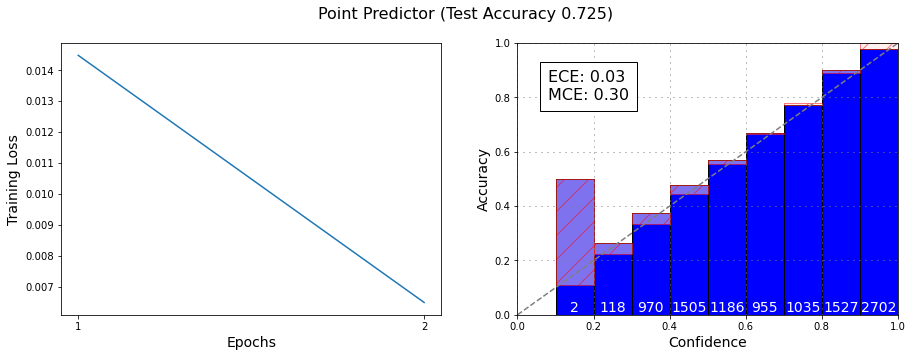

In [28]:
exp.eval_model("Point Predictor", pp, losses, 1, testloader, device)

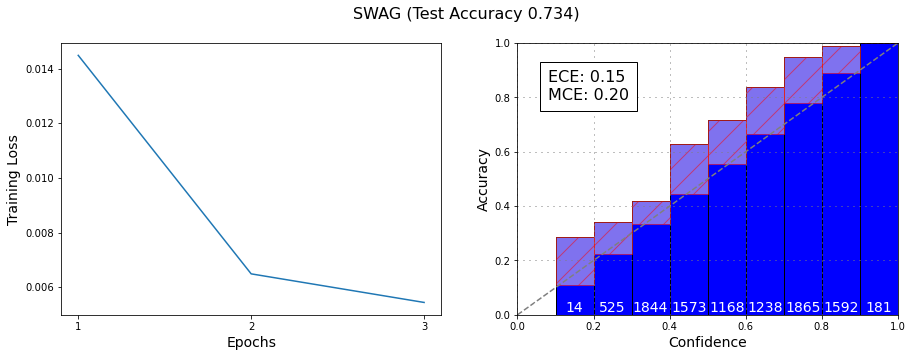

In [29]:
exp.eval_model("SWAG", swag, swag_losses, 100, testloader, device)

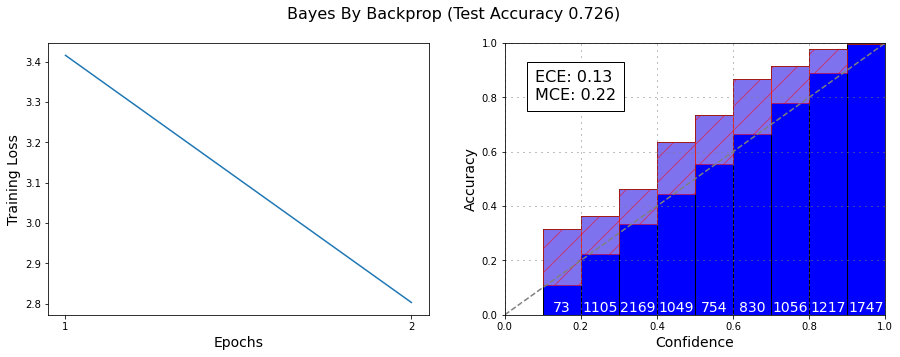

In [30]:
exp.eval_model("Bayes By Backprop", bbb, bbb_loss, 100, testloader, device)